Computational Simulation of Materials. Group members: Nikolaus Felder, Benedikt Schier, Maksim Feldman, Konstantin Korkin

initialization of positions, calculation of energies, calculation of forces

In [1]:
#Initialization for positions
import numpy as np
import scipy as sp
from scipy.stats import truncnorm
from numpy import arange
from multiprocessing import Pool
import matplotlib.pyplot as plt


def init_pos(N,L):
    def get_truncated_normal(mean=0, sd=1, low=-L/2, upp=L/2):
        return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    X = get_truncated_normal()
    positions = X.rvs(size=(N,3))
    return positions

#Calculation of energies
def inner_energy(ri,rj):
    u = 0
    epsilon = 1.000
    sigma = 1.000
    Rc = 2.500
    rij = np.linalg.norm(np.subtract(ri,rj))
    if rij <= Rc:
        u = 4*epsilon*((rij/sigma)**(-12)-(rij/sigma)**(-6))-4*epsilon*((Rc/sigma)**(-12)-(Rc/sigma)**(-6))
    return u

def inner_energy_conventional(ri,rj):
    epsilon = 1.000
    sigma = 1.000
    rij = np.linalg.norm(np.subtract(ri,rj))
    u = 4*epsilon*((rij/sigma)**(-12)-(rij/sigma)**(-6))
    return u

def calculate_energy(positions, L):
    alpha = 0.0001*(positions.size/3)**(-2/3)
    N = int(positions.size/3)
    energy = 0.0
    for i in range (N):
        energy += alpha*np.linalg.norm(positions[i])**2
    for j in range (N):
        for i in range (j):
            energy += inner_energy(positions[i],positions[j])
    return energy

#Calculation of forces
def calculate_forces(positions, L):
    N = positions.shape[0]
    epsilon = 1.000
    sigma = 1.000
    Rc = 2.500
    alpha = 0.0001*N**(-2/3)
    forces = 2*alpha*positions

    def pot_derivative(rij):
        temp = (sigma/rij)**6
        return 4 * epsilon * (6 * temp - 12 * temp ** 2)/rij

    for i in range (N):
        for j in range (i+1,N):
            Rij = np.subtract(positions[i],positions[j])
            Rij += -L*np.rint(Rij/L)
            rij = np.linalg.norm(Rij)
            if rij <=Rc:
                f_rij = pot_derivative(rij)
                forces[i] += f_rij/rij*Rij
                forces[j] -= f_rij/rij*Rij
    return -forces




linesearch and conjugate gradient minimization

In [2]:
#Perform linesearch
def linesearch(positions,direction,delta,LStol,MaxLSSteps):
    
    N = positions.shape[0]
    L = (N / 0.01) ** (1 / 3)
    r0 = positions
    r1 = r0 + delta * direction
    r2 = r1 + delta * direction
    u0 = calculate_energy(r0, L)
    u1 = calculate_energy(r1, L)
    u2 = calculate_energy(r2, L)
    def bisection_min(lower, upper): #bisection to find position with minimum energy between lower and upper pos
        u_up = calculate_energy(upper, L)
        u_low = calculate_energy(lower, L)
        M = lower
        while(abs(u_up - u_low) > LStol * abs(calculate_energy(M, L))):
            M = (lower + upper) / 2
            sample1 = (lower + M) / 2
            sample2 = (M + upper) / 2
            if(calculate_energy(sample1, L) < calculate_energy(sample2, L)):
                upper = M
                u_up = calculate_energy(M, L)
                continue
            else:
                lower = M
                u_low = calculate_energy(M, L)
                continue
        return M
    candidate = bisection_min(r0, r1)
    if(u2 > u1 and u1 > u0):
        candidate = bisection_min(r0, r1)
    
        return candidate, calculate_energy(candidate, L)
    k = 1
    while(k <= MaxLSSteps):

        if(u2 > u1 and u0 > u1):
            candidate = bisection_min(r0, r2)
            return candidate, calculate_energy(candidate, L)
        else:
            r0 = r1
            r1 = r2
            r2 = r1 + delta * direction
            u0 = u1
            u1 = u2
            u2 = calculate_energy(r2, L)
            k += 1
    return candidate, calculate_energy(candidate, L)

#Perform conjugate gradient minimization
def conjugate_gradient(positions, delta=0.001, LStol=10 ** (-8), MaxLSSteps=100000, ECtol=10 ** (-10), MaxCGSteps=100000):
    k = 1
    N = positions.shape[0]
    L = (N / 0.01) ** (1 / 3)

    gamma = np.zeros(N)
    current_position = positions.copy()
    current_energy = calculate_energy(current_position, L)
    direction = calculate_forces(current_position, L)
    direction = direction / np.linalg.norm(direction)
    history = np.zeros(MaxCGSteps)
    history.fill(np.nan)
    while (k <= MaxCGSteps):
        previous_energy, previous_position = current_energy, current_position.copy()
        result = linesearch(previous_position, direction, delta, LStol, MaxLSSteps)
        current_energy,current_position = result[1],result[0]
        history[k-1] = current_energy


        f_prev = calculate_forces(previous_position, L)
        f_curr = calculate_forces(current_position, L)
        for j in range(N):
            gamma[j] = np.dot((f_curr[j] - f_prev[j]),f_curr[j])/ np.dot(f_prev[j],f_prev[j])
            direction[j] = f_curr[j] + gamma[j] * direction[j]
            direction[j] = direction[j]/np.linalg.norm(direction[j])
        if (abs(previous_energy - current_energy) < ECtol * abs(current_energy)):
            return current_position, current_energy, history

        k += 1
    return current_position, current_energy, history

Main: Simulation parameters and array initialization

In [3]:
# Simulation parameters
upperbound_N = 20
lowerbound_N = 2
iterations_M = 2
Max_CGSteps = 100000
delta = 0.001
MaxLSSteps = 100000
ECtol = 10**(-10)
LStol = 10**(-8)

# Initialize arrays to save simulation data
Max_CGSteps_needed = np.empty(upperbound_N)
Max_CGSteps_needed.fill(np.nan)
min_energies = np.zeros(upperbound_N)
min_energies.fill(float('inf'))
min_iterations = np.zeros((upperbound_N))
min_positions = np.zeros((20,20,3))
min_energy_perstep = np.zeros((upperbound_N,Max_CGSteps))
min_energy_perstep.fill(np.NaN)



Main: Task 2

In [4]:
# Task 2 ------------------------------------------------------------------------------

for N in range(lowerbound_N,upperbound_N):
    L = (N/0.01)**(1/3)

    for M in range (iterations_M):
        print('N=',N,' M=',M)
        positions = init_pos(N,L)
        results = conjugate_gradient(positions=positions, delta=delta, LStol=LStol, MaxLSSteps=MaxLSSteps, ECtol=ECtol, MaxCGSteps=Max_CGSteps)
        min_energy = results[1]
        if min_energy < min_energies[N]:
            min_energies[N] = min_energy
            min_position = results[0]
            min_positions[N] = np.reshape(np.append(np.reshape(min_position,(N,3)),np.zeros((20-N,3))),(20,3))
            energy_perstep = results[2]     
    tmp_energy = energy_perstep[~np.isnan(energy_perstep)]
    min_energy_perstep[N,0:tmp_energy.size] = tmp_energy
    Max_CGSteps_needed[N] = tmp_energy.size


N= 2  M= 0
N= 2  M= 1
N= 3  M= 0
N= 3  M= 1
N= 4  M= 0
N= 4  M= 1
N= 5  M= 0
N= 5  M= 1
N= 6  M= 0
N= 6  M= 1
N= 7  M= 0
N= 7  M= 1
N= 8  M= 0
N= 8  M= 1
N= 9  M= 0
N= 9  M= 1
N= 10  M= 0
N= 10  M= 1
N= 11  M= 0
N= 11  M= 1
N= 12  M= 0
N= 12  M= 1
N= 13  M= 0
N= 13  M= 1
N= 14  M= 0
N= 14  M= 1
N= 15  M= 0
N= 15  M= 1
N= 16  M= 0
N= 16  M= 1
N= 17  M= 0
N= 17  M= 1
N= 18  M= 0
N= 18  M= 1
N= 19  M= 0
N= 19  M= 1


Plot: Task 2

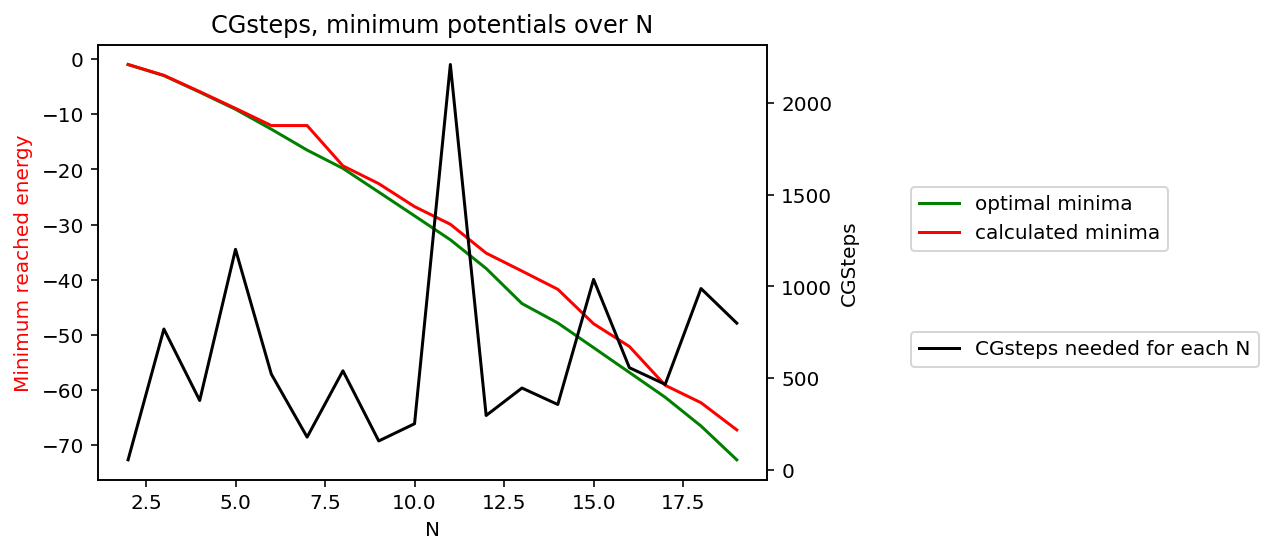

In [5]:
%config InlineBackend.figure_format = 'retina'
# Plot minimum potential energy and CGSteps over N
x_N = np.arange(0,upperbound_N,1)
U_frompdf = np.array([np.nan,np.nan,1.0,3.0,6.0,9.103852,12.712062,16.505384,19.821489,24.113360,28.422532,32.765970,37.967600,44.326801,47.845157,52.322627,56.815742,61.317995,66.530949,72.659782])
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_N, -U_frompdf[0:upperbound_N:1], color = 'green',label = 'optimal minima')
ax1.plot(x_N,min_energies, color = 'red', label = 'calculated minima')
ax1.set_xlabel('N')
ax1.set_ylabel('Minimum reached energy', color = 'red')
plt.legend(loc ='center left',bbox_to_anchor=(1.2,0.6))

ax2 = ax1.twinx()
ax2.set_ylabel('CGSteps', color = 'black')
ax2.plot(x_N,Max_CGSteps_needed, color = 'black', label='CGsteps needed for each N')

plt.title('CGsteps, minimum potentials over N')
plt.legend(loc ='center left',bbox_to_anchor=(1.2,0.3))
plt.show()


Main: Task 3

C:\Users\Nikolaus\AppData\Local\Temp/ipykernel_5736/1701843661.py:12: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(min_energy_perstep, axis=0)
C:\Users\Nikolaus\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


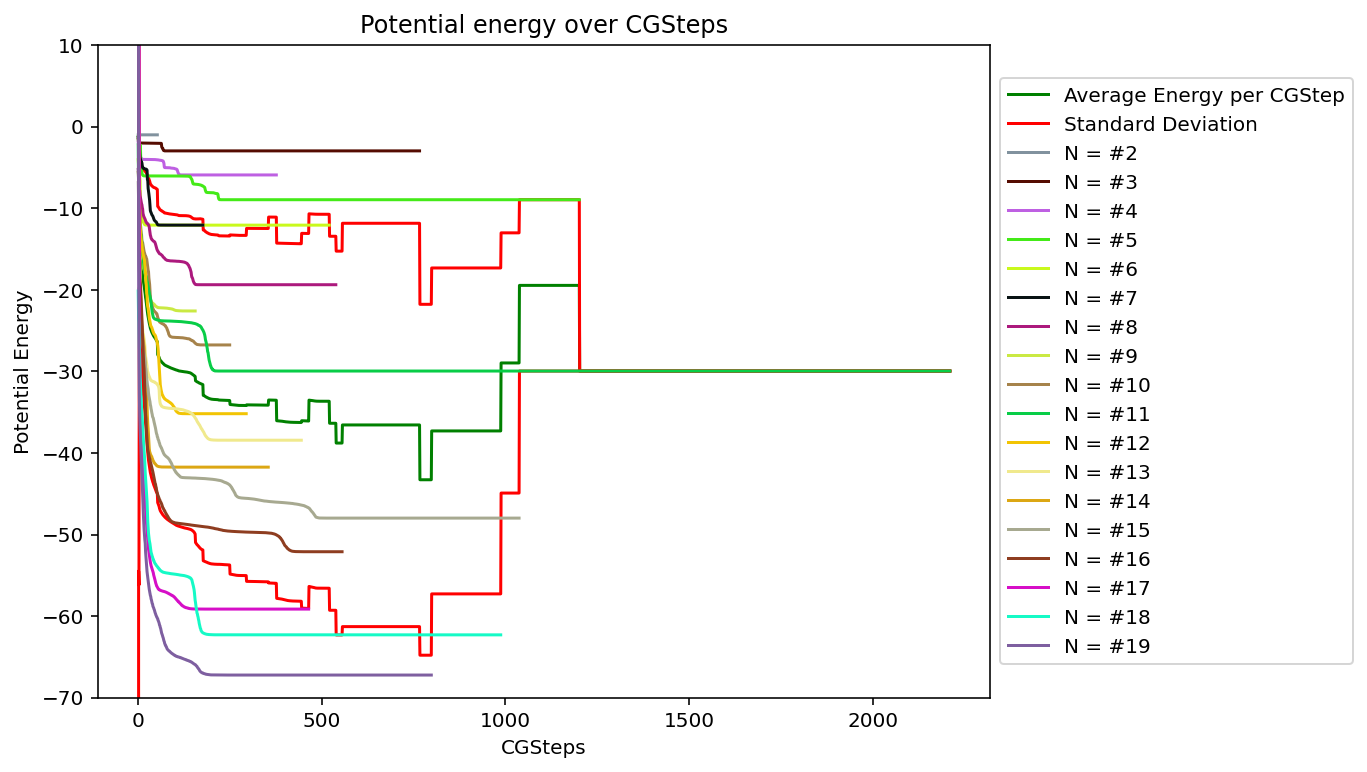

In [6]:
# Task 3 -------------------------------------------------------------------------------
%config InlineBackend.figure_format = 'retina'
# Plot potential, average and standard deviation of energy over CGSteps for N simulations
plt.figure(figsize = (8,6))
plt.title('Potential energy over CGSteps')
plt.xlabel('CGSteps')
plt.ylabel('Potential Energy')
plt.ylim((-70,10))

# Calculate average energy and standard deviation at each CGStep for N simulations
j = 0
avg = np.nanmean(min_energy_perstep, axis=0)
stand_dev = np.nanstd(min_energy_perstep, axis = 0)
x_avg = np.array(range(0,Max_CGSteps))
plt.plot(x_avg,avg, color = 'green', label = 'Average Energy per CGStep')
plt.plot(x_avg, avg + stand_dev, color = 'red', label = 'Standard Deviation')
plt.plot(x_avg, avg - stand_dev, color = 'red')

# Plot potential energy over CGSteps
for i in range(lowerbound_N,upperbound_N):
    x_steps = np.array(range(0,Max_CGSteps))
    plt.plot(x_steps,min_energy_perstep[i],color = np.random.rand(3,),label=f"N = #{i}")

plt.legend(loc ='center left',bbox_to_anchor=(1,0.5))
plt.show()


Main: Task 4

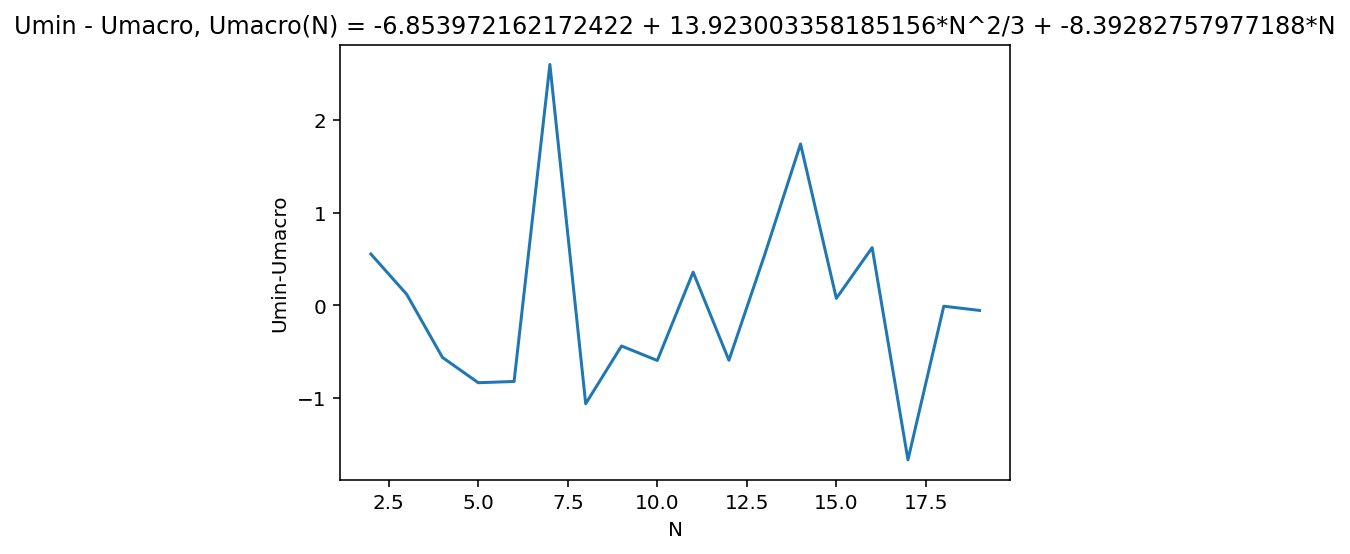

In [7]:
# Task 4 ---------------------------------------------------------------------------------
%config InlineBackend.figure_format = 'retina'
import scipy.optimize as opt

# Fit macroscopic scaling estimate to data
def estimate(N,a,b,c):
    return a + b*N**(2/3) + c*N

x_fit = np.arange(lowerbound_N,upperbound_N,1)
y = min_energies[np.logical_not(np.isinf(min_energies))]
params, params_covariance = opt.curve_fit(estimate, x_fit, y)
estimates = [estimate(j, *params) for j in x_fit]

# Plot potential energies substracted from fitted curve
plt.plot(x_fit, y - estimates)
plt.xlabel('N')
plt.ylabel('Umin-Umacro')
plt.title(f'Umin - Umacro, Umacro(N) = {params[0]} + {params[1]}*N^2/3 + {params[2]}*N')
plt.show()

# END -------------------------------------------------------------------------------------



module load scipy if not found

In [8]:
#import sys
#!{sys.executable} -m pip install scipy
